In [1]:
import sys
sys.path.append('/Users/ekang/anaconda2/lib/python2.7/site-packages')

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

Using Theano backend.


In [3]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 90  #720
COLS = 160 #1280
CHANNELS = 3

# Loading and Preprocessing Data


In [4]:
def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    # cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    # bicubic interpolation is often chosen over bilinear interpolation or nearest neighbor in image resampling
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    
    return im

In [15]:
files = []
y_all = []

for fish in FISH_CLASSES:
    fish_files = get_images(fish)
    
    # Add elements to empty list
    files.extend(fish_files)
    
    # repeat fish, len(fish_files) times
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    
    print("{0} photos of {1}".format(len(fish_files), fish))
    
y_all = np.array(y_all)

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT


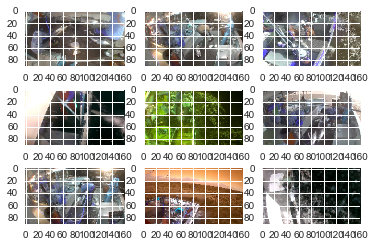

In [16]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(read_image(TRAIN_DIR+files[i]))

# show the plot
plt.show()

In [17]:
# uint8	Unsigned integer (0 to 255)
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(files):
    X_all[i] = read_image(TRAIN_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777
(3777, 90, 160, 3)


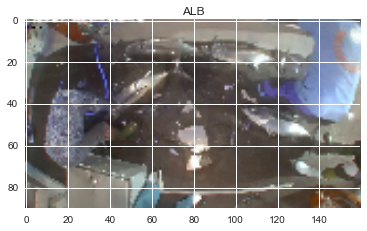

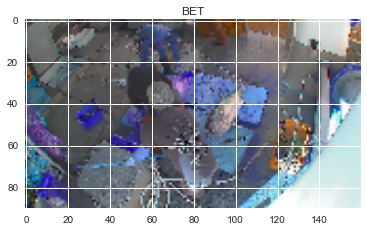

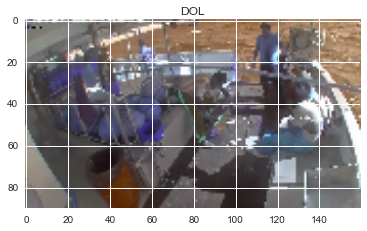

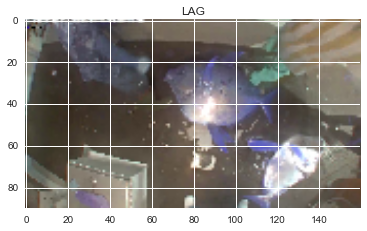

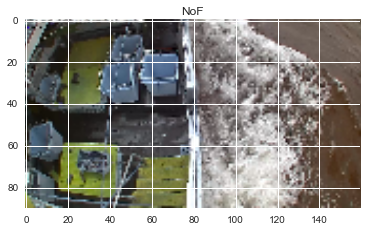

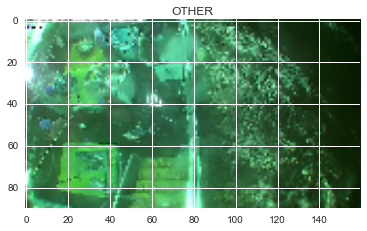

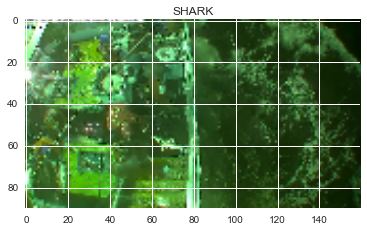

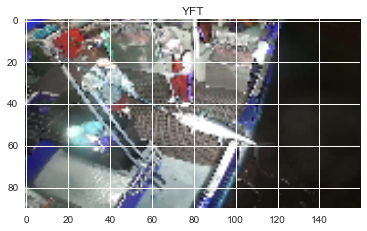

In [8]:
# Check out a fish from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

# Splitting the Training Data

One-Hot_encode the labels, then create a stratified train/validattion split.

In [19]:
# One Hot Encoding Labels
# Categorical to Numerical
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

# The Model
Pretty typical CNN in Keras with a plenty of dropout regularization between the fully connected layers

In [5]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    # must call BackEnd to create custom activation function
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(FISH_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [11]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
#model.fit(X_train, y_train, batch_size=64, nb_epoch=1,
#              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

history = model.fit(X_train, y_train, batch_size=64, nb_epoch=10, validation_split=0.2, verbose=1, shuffle=True)

Train on 2416 samples, validate on 605 samples
Epoch 1/10
2416/2416 [==============================] - 417s - loss: 1.8444 - val_loss: 1.7355

['loss', 'val_loss']


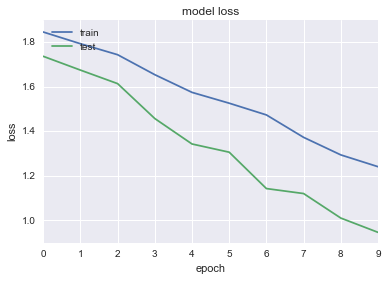

In [13]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [14]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_valid, preds)))

756/756 [==============================] - 42s     

# Predicting the Test Set
Finishing off with predictions on the test set.

In [15]:
test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=1)

1000/1000 [==============================] - 55s     

In [16]:
submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.303679,0.125576,0.226343,0.038473,0.939595,0.045621,0.059140,0.368764
1,img_00007.jpg,0.959874,0.072561,0.022520,0.239530,0.102453,0.126330,0.028608,0.264062
2,img_00009.jpg,0.830102,0.610912,0.059959,0.068134,0.435520,0.611481,0.151285,0.175787
3,img_00018.jpg,0.994726,0.007246,0.001846,0.006392,0.061065,0.066713,0.002599,0.092083
4,img_00027.jpg,0.928245,0.037267,0.014857,0.043582,0.081794,0.241697,0.226556,0.846565


In [17]:
submission.to_csv("Feb3-Submission-EugineKang.csv",sep=",",index=False)

# Load Previous Model and Weight

In [24]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    # must call BackEnd to create custom activation function
    return (x - K.mean(x)) / K.std(x)

In [25]:
from keras.models import model_from_json

In [28]:
# later...

# load json and create model
#json_file = open('jeffdelaney_model.json','r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("jeffdelaney_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model.compile(loss=objective, optimizer=optimizer)

In [29]:
from keras.callbacks import ModelCheckpoint

In [31]:
# checkpoint
filepath = "weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit(X_train, y_train, batch_size=64, nb_epoch=500, validation_split=0.2, verbose=1, shuffle=True, callbacks=callbacks_list)


Train on 2416 samples, validate on 605 samples
Epoch 1/500
2416/2416 [==============================] - 362s - loss: 1.1069 - val_loss: 0.7382
Epoch 2/500
2416/2416 [==============================] - 361s - loss: 1.0586 - val_loss: 0.6946
Epoch 3/500
2416/2416 [==============================] - 363s - loss: 0.9854 - val_loss: 0.6469
Epoch 4/500
2416/2416 [==============================] - 362s - loss: 0.9377 - val_loss: 0.6013
Epoch 5/500
2416/2416 [==============================] - 361s - loss: 0.9143 - val_loss: 0.6136
Epoch 6/500
2416/2416 [==============================] - 362s - loss: 0.8372 - val_loss: 0.5493
Epoch 7/500
2416/2416 [==============================] - 362s - loss: 0.7930 - val_loss: 0.5266
Epoch 8/500
2416/2416 [==============================] - 366s - loss: 0.7676 - val_loss: 0.4918
Epoch 9/500
2416/2416 [==============================] - 362s - loss: 0.7570 - val_loss: 0.4402
Epoch 10/500
2416/2416 [==============================] - 362s - loss: 0.6799 - val_loss:

KeyboardInterrupt: 

# Load Epoch N + 10 Weights

In [1]:
import sys
sys.path.append('/Users/ekang/anaconda2/lib/python2.7/site-packages')

import os, cv2, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 90  #720
COLS = 160 #1280
CHANNELS = 3

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    # cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    # bicubic interpolation is often chosen over bilinear interpolation or nearest neighbor in image resampling
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    
    return im

optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def center_normalize(x):
    # must call BackEnd to create custom activation function
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(FISH_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

Using Theano backend.


In [10]:
# load weights into new model
model.load_weights("Jeff Delaney model and weights/weights-improvement-09-0.40.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [11]:
#test_files = [im for im in os.listdir(TEST_DIR)]
#test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

#for i, im in enumerate(test_files): 
#    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=1)

1000/1000 [==============================] - 47s     

In [12]:
submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.007650,0.006602,0.001086,0.000095,0.994839,0.000090,0.000041,0.000738
1,img_00007.jpg,0.996950,0.000205,0.002055,0.047330,0.000054,0.007000,0.000148,0.242701
2,img_00009.jpg,0.837314,0.274818,0.001421,0.001384,0.070502,0.555941,0.025657,0.002686
3,img_00018.jpg,0.999755,0.000124,0.000647,0.000042,0.000091,0.016570,0.000038,0.002484
4,img_00027.jpg,0.764727,0.017743,0.001023,0.003510,0.031054,0.047260,0.033021,0.052906


In [13]:
submission.to_csv("submission/Feb6c-Submission-EugineKang.csv",sep=",",index=False)